
   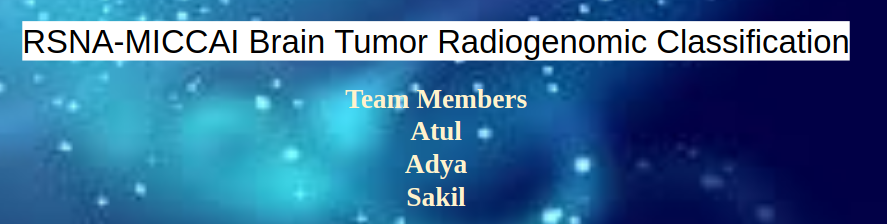

# **Brain Tumor Radiogenomic Classification**

* A malignant tumor in the brain is a life-threatening condition which is known as glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year.
* Glioblastoma is a life-threatning brain tumor which is caused by the presence of a specific genetic sequence in the tumor known as MGMT promoter methylation.
* In today's world ,genetic analysis of cancer requires surgery to extract a tissue sample and it can take several weeks to determine the genetic characterization of the tumor.
* Depending upon the results and type of initial therapy chosen, a subsequent surgery may be necessary. 

# **Objective**

* To develope an accurate method in  predicting the genetics of the cancer through imaging which will help in reducing the sugeries required to perform an biopsy to determine if there is a tumor or not. 

# **MRI and Scan Types**

* Magnetic resonance imaging (MRI) is one of the most commonly used tests in neurology and neurosurgery. 
* MRI provides exquisite detail of brain, spinal cord and vascular anatomy, and has the advantage of being able to visualize anatomy in all three planes: axial, sagittal and coronal.
* T1, T2 and FLAIR are different MRI Imaging

# **Different types of Scan**
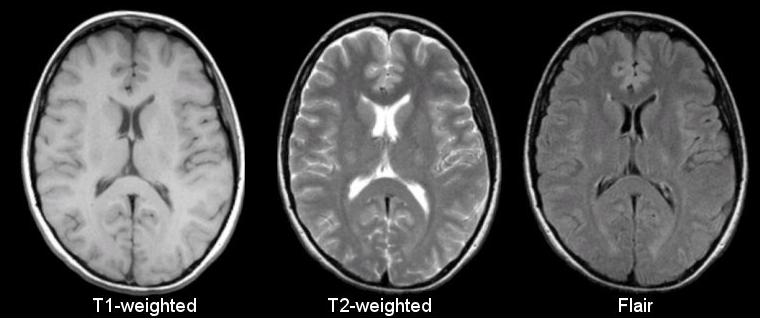

In [ ]:
# #for dicom files
# !pip install -q pydicom

In [ ]:
#importing the necessary libraries
import os
import re 
import glob
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Pydicom related imports
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import tensorflow as tf
# W&B for experiment tracking


In [ ]:
# import wandb
# wandb.login()

In [ ]:
#reading the data
train_data = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')
print('Number of records: ', len(train_data))
train_data.head()

# **Training data Information**

* There are 585 patients and each patient is identified by unique id,BraTS21ID.
* Each patient consists of four structural multi-parametric MRI (mpMRI) scans.They are:
    * Fluid Attenuated Inversion Recovery (FLAIR)
    * T1-weighted pre-contrast (T1w)
    * T1-weighted post-contrast (T1Gd)
    * T2-weighted (T2)
* Each sub-folder contains multiple scans in Dicom format with name - Image-X.dcm where X increases from 1 to N. 
* MGMT_value 1 corresponds to the presence of MGMT promoter and 0 corresponds to absence.

In [ ]:
#checking the distribution of the class
plt.figure(figsize=(5, 5))
ax = sns.countplot("MGMT_value",data=train_data)
ax.set_title("Distribution of class Labels");
print(train_data.MGMT_value.value_counts())

# **Analysis**

* The dataset is not entirely balanced.

# **Checking total number of files (.dcm)**

In [ ]:
#checking total number of .dcm files
filenames = glob.glob('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/*/*/*')
print(f'Total number of files: {len(filenames)}')

# **Analysis**

* There are 348641 dcm files

# **Checking the distribution of files based on scan types**

In [ ]:
scan_label_dist = {
    'FLAIR': [],
    'T1w': [],
    'T1wCE': [],
    'T2w': []
}

for filename in tqdm(filenames):
    scan = filename.split('/')[-2]
    if scan=='FLAIR':
        scan_label_dist['FLAIR'].append(filename)
    elif scan=='T1w':
        scan_label_dist['T1w'].append(filename)
    elif scan=='T1wCE':
        scan_label_dist['T1wCE'].append(filename)
    else:
        scan_label_dist['T2w'].append(filename)
        
print("Number of files per scan:")
print("<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>")
print("\n")
print('Size of FLAIR scan: {}, T1w scan: {}, T1wCE scan: {}, T2w scan: {}'.format(len(scan_label_dist['FLAIR']), 
                                                                                  len(scan_label_dist['T1w']),
                                                                                  len(scan_label_dist['T1wCE']),
                                                                                  len(scan_label_dist['T2w'])))

# **Analysis**

* There are 74248 FAIR scan
* There are 77627 T1w scan
* There are 96766 T1wCE scan
* There are 100000 T2w scan


In [ ]:
# CONFIG = {'IMG_SIZE': 224, 
#           'competition': 'rsna-miccai-brain', 
#           '_wandb_kernel': 'sakil786'}

In [ ]:
# run = wandb.init(project='brain-tumor-viz', config=CONFIG)
# data = [['FLAIR', 74248], ['T1w', 77627], ['T1wCE', 96766], ['T2w', 100000]]
# table = wandb.Table(data=data, columns = ["Scan Type", "Num Files"])
# wandb.log({"my_bar_chart_id" : wandb.plot.bar(table, "Scan Type", "Num Files",
#                                title="Scan Types vs Number of Dicom files")})
# run.finish()

# Barchart for different types of Scan



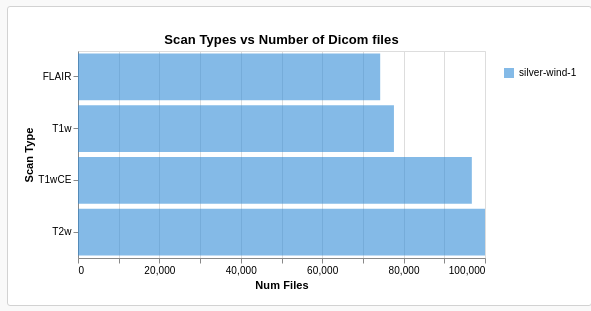

# **Reading DICOM File**

In [ ]:

def dicomFileTransformation(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

# **Note**
* MONOCHROME1 indicates that the greyscale ranges from bright to dark with ascending pixel values
*  MONOCHROME2 ranges from dark to bright with ascending pixel values.
* The Value Of Interest(VOI) LUT transformation transforms the modality pixel values into pixel values which are meaningful for the user or the application. 


In [ ]:
data = dicomFileTransformation(filenames[16])
print('Shape of data: ', data.shape)

plt.figure(figsize=(5, 5))
plt.imshow(data, cmap='gray');

# **Analysis**

* Each MRI image has a resolution of 512x512 pixels.

In [ ]:
patient_ids = os.listdir('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train')
IDX = np.random.choice(len(patient_ids))

patient_id = patient_ids[IDX]
print(f'Patient ID: {patient_id}')

In [ ]:
def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [ ]:
# #checking the number of images per patient id
# flair_data = []
# flair_filenames = os.listdir(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/FLAIR/')
# flair_filenames = sorted_nicely(flair_filenames)
# for filename in flair_filenames:
#     flair_data.append(dicomFileTransformation(f'../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/{patient_id}/FLAIR/{filename}'))
    
# print(f'Number of FLAIR images for the patient: {len(flair_data)}')

In [ ]:
# run = wandb.init(project='brain-tumor-viz', config=CONFIG)
# wandb.log({f"flair_{patient_id}": [wandb.Image(image) for image in flair_data]})
# run.finish()

In [ ]:
#copying the data
train=train_data.copy()

In [ ]:
#adding imfolder in the dataframe
train["imfolder"] = ['{0:05d}'.format(s) for s in train["BraTS21ID"]]
train.head()

In [ ]:
#adding the path in the dataframe
train_path = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/train"

train["path"] = [os.path.join(train_path,s) for s in train["imfolder"]  ]
train.head()

In [ ]:
scans_label = ["FLAIR","T1w","T1wCE","T2w"]

In [ ]:
#counting the number of dcm files per patient
for scan in scans_label:
    train[scan +"_count"] = [ len(os.listdir(os.path.join(train["path"].iloc[s],scan))) for s in tqdm(range(len(train))) ]

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
#checking which patient has same files in all types of scans
allsame_column = [train["FLAIR_count"].iloc[s] ==   train["T1w_count"].iloc[s] ==train["T1wCE_count"].iloc[s] ==train["T2w_count"].iloc[s] 
          for s in range(len(train))]

In [ ]:
train["allsame_column"] = allsame_column
train

In [ ]:
train["allsame_column"].sum()

# **Analysis**

* 63 patients have same number of dcm files in all scan

In [ ]:
#checking the percentage of same dcm files
train["allsame_column"].sum()/len(train) * 100

In [ ]:
#printing same dcm files
train[train["allsame_column"]]

In [ ]:
def makepath(row_ID,scan):
    """ Function to keep all categories files in their respective path""" 
    temp_folder = train["path"].iloc[row_ID]
    temp_folder2 = os.path.join(temp_folder,scan)
    temp_files = os.listdir(temp_folder2)
    imagenum = [s.split("-")[1] for s in temp_files]
    imagenum = [s.split(".")[0] for s in imagenum]
    temp_path = [os.path.join(temp_folder2,s) for s in temp_files]
    tempdf = pd.DataFrame()
    tempdf["image_num"] = imagenum
    tempdf["image_num"] = tempdf["image_num"].astype("int")
    tempdf["temp_path"] = temp_path
    tempdf = tempdf.sort_values("image_num").reset_index(drop=True)
    finpath = tempdf["temp_path"]
    return finpath

In [ ]:
scans_label = ["FLAIR","T1w","T1wCE","T2w"]

In [ ]:
row_id=64

sampledf = pd.DataFrame()
for scan in scans_label:
    sampledf[scan + "_path"] = makepath(row_id,scan)

In [ ]:
sampledf.head(3)


In [ ]:
sampledf['FLAIR_path'].head()

In [ ]:
def makeimg(path):
    dataset = pydicom.filereader.dcmread(path)
    img = dataset.pixel_array
    return img

In [ ]:
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

#showing the scans for patient_id=100 and row_id=64 ,whose MGMT_value=1
for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(scans_label):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)

# **Analysis**
* There are 22 dcm files for the patient_id 100 whose MGMT_value=1

In [ ]:
row_id = 65

sampledf = pd.DataFrame()
for scan in scans_label:
    sampledf[scan + "_path"] = makepath(row_id,scan)
#showing the scans for patient_id=100 and row_id=65 ,whose MGMT_value=0
print("MGMT_value = " + str(train["MGMT_value"].iloc[row_id]))

for row in range(len(sampledf)):
    plt.figure(figsize=(80,10))
    for num,scan in enumerate(scans_label):
        img = makeimg(sampledf[scan + "_path"].iloc[row])
        plt.subplot(4,25,num+1)
        #plt.axis("off")
        plt.imshow(img)
        
        if row==0:
            plt.title(scan,fontsize=18)
        if num==0:
            plt.ylabel("row=" + str(row),fontsize=18)



# **Analysis**
* There are 23 dcm files for the patient_id 102 whose MGMT_value=0

# **Model Training**

In [ ]:
import os
import glob
from tqdm import tqdm_notebook as tqdm
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install efficientnet-pytorch

In [ ]:
# rm efficientnet-pytorch

In [ ]:
import sys
sys.path.append('../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D')
sys.path.append('../input/efficientnet-pytorch2')
sys.path.append('../input/efficientnet/EfficientNet-PyTorch-master/')

# inspecting Labels

In [ ]:
path = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification'
train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
print('Num of train samples:', len(train_data))
train_data.head()

# Augmentation

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.1, aug)

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

# MRI Slice Loading/Processing

In [ ]:
def dicom2array(paths, voi_lut=True, fix_monochrome=True, remove_black_boundary=True, aug = False):
    
    for path in paths:
        dicom = pydicom.read_file(path)
        # VOI LUT (if available by DICOM device) is used to
        # transform raw DICOM data to "human-friendly" view
        if voi_lut:
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        if data.max() > 0.0: # avoiding black images (if possible)
            break
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    if remove_black_boundary: # we get slightly more details
        (x, y) = np.where(data > 0)
        if len(x) > 0 and len(y) > 0:
            x_mn = np.min(x)
            x_mx = np.max(x)
            y_mn = np.min(y)
            y_mx = np.max(y)
            if (x_mx - x_mn) > 10 and (y_mx - y_mn) > 10:
                data = data[:,np.min(y):np.max(y)]
    data = cv2.resize(data, (512, 512))
    if aug and random.randint(0,1) == 1: # augmenting only 50% of the time
        data = seq(images=data)
    return data


def load_3d_dicom_images(scan_id, split = "train", channel_expand = True):
    """
    we will use some heuristics to choose the slices to avoid any numpy zero matrix (if possible)
    """
    flair = sorted(glob.glob(f"{path}/{split}/{scan_id}/FLAIR/*.dcm"))
    t1w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1w/*.dcm"))
    t1wce = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1wCE/*.dcm"))
    t2w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T2w/*.dcm"))
    
    
    flair_img = np.array([dicom2array(a) for a in flair[len(flair)//2 - 32:len(flair)//2 + 32]]).T
    
    if len(flair_img) == 0:
        flair_img = np.zeros((256, 256, 64))
    elif flair_img.shape[-1] < 64:
        n_zero = 64 - flair_img.shape[-1]
        flair_img = np.concatenate((flair_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(flair_img.shape)
        
    
    
    t1w_img = np.array([dicom2array(a) for a in t1w[len(t1w)//2 - 32:len(t1w)//2 + 32]]).T
    
    if len(t1w_img) == 0:
        t1w_img = np.zeros((256, 256, 64))
    elif t1w_img.shape[-1] < 64:
        n_zero = 64 - t1w_img.shape[-1]
        t1w_img = np.concatenate((t1w_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(t1w_img.shape)
    
    
    t1wce_img = np.array([dicom2array(a) for a in t1wce[len(t1wce)//2 - 32:len(t1wce)//2 + 32]]).T
    
    if len(t1wce_img) == 0:
        t1wce_img = np.zeros((256, 256, 64))
    elif t1wce_img.shape[-1] < 64:
        n_zero = 64 - t1wce_img.shape[-1]
        t1wce_img = np.concatenate((t1wce_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(t1wce_img.shape)
    
    
    t2w_img = np.array([dicom2array(a) for a in t2w[len(t2w)//2 - 32:len(t2w)//2 + 32]]).T
    
    if len(t2w_img) == 0:
        t2w_img = np.zeros((256, 256, 64))
    elif t2w_img.shape[-1] < 64:
        n_zero = 64 - t2w_img.shape[-1]
        t2w_img = np.concatenate((t2w_img, np.zeros((256, 256, n_zero))), axis = -1)
    #print(t2w_img.shape)
    
    return np.concatenate((flair_img, t1w_img, t1wce_img, t2w_img), axis = -1) if not channel_expand else np.moveaxis(np.array((flair_img, t1w_img, t1wce_img, t2w_img)), 0, -1)


def load_rand_dicom_images(scan_id, split = "train", aug = False):
    """
    send 4 random slices of each modality
    """
    if split != "train" and split != "test":
        split = "train"
    flair = sorted(glob.glob(f"{path}/{split}/{scan_id}/FLAIR/*.dcm"))
    flair_img = dicom2array(random.sample(flair, max(len(flair)//2, 1)), aug = aug)
    t1w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1w/*.dcm"))
    t1w_img = dicom2array(random.sample(t1w, max(len(t1w)//2, 1)), aug = aug)
    t1wce = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1wCE/*.dcm"))
    t1wce_img = dicom2array(random.sample(t1wce, max(len(t1wce)//2, 1)), aug = aug)
    t2w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T2w/*.dcm"))
    t2w_img = dicom2array(random.sample(t2w, max(len(t2w)//2, 1)), aug = aug)
    
    return np.array((flair_img, t1w_img, t1wce_img, t2w_img)).T

# Data Loader

In [ ]:
# let's write a simple pytorch dataloader

class BrainTumor4C(Dataset): # 4 channel data-loader
    def __init__(self, path = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification', split = "train", validation_split = 0.2):
        # labels
        train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
        self.labels = {}
        brats = list(train_data["BraTS21ID"])
        mgmt = list(train_data["MGMT_value"])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        if split == "valid":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/train/" + "/*"))]
            self.ids = self.ids[:int(len(self.ids)* validation_split)] # first 20% as validation
        elif split == "train":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/{split}/" + "/*"))]
            self.ids = self.ids[int(len(self.ids)* validation_split):] # last 80% as train
        else:
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/{split}/" + "/*"))]
            
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        imgs = load_rand_dicom_images(self.ids[idx], self.split, aug = False)
        
        transform = transforms.Compose([transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
        imgs = transform(imgs)
        
        imgs = imgs - imgs.min()
        imgs = (imgs + 1e-5) / (imgs.max() - imgs.min() + 1e-5)
        
        if self.split != "test":
            label = self.labels[self.ids[idx]]
            return torch.tensor(imgs, dtype = torch.float32), torch.tensor(label, dtype = torch.long)
        else:
            return torch.tensor(imgs, dtype = torch.float32), self.ids[idx]

In [ ]:
# testing the dataloader
test_dataset = BrainTumor4C(split = "test")
test_bs = 8
test_loader = DataLoader(test_dataset, batch_size = test_bs, shuffle=True)

In [ ]:
for img, idx in test_loader:
    print(img.shape)
    print(img.max())
    print(img.mean())
    print(img.min())
    print(idx)
    break

# Model: EfficientNet-3D B0 / EfficientNet B1

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
MODEL = "4C" # ["4C", "3D", "4C+3D"]

In [ ]:
# !mkdir rsna-efficientnet3db0

In [ ]:
if MODEL == "3D":
    PATH = "../input/rsna-efficientnet3db0/best_roc_0.29_loss_1826.83.pt"
    model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=4)
    model.load_state_dict(torch.load(PATH))
    model.eval()

In [ ]:
# !pip install --upgrade efficientnet-pytorch


In [ ]:
# !mkdir effb14c1/best_roc_0.35_loss_39.450.pt

In [ ]:
# PATH = "best_roc_0.35_loss_39.450.pt"
# torch.save(model.state_dict(), PATH)

In [ ]:
# PATH="best_roc_0.35_loss_39.451.pt"
# torch.save(model.state_dict(), PATH)

In [ ]:
# !pip install efficientnet_pytorch

In [ ]:
# pwd

In [ ]:
# cd ../input/efficientnetpytorch

In [ ]:
# cd EfficientNet-PyTorch-master

In [ ]:
# cd efficientnet_pytorch

In [ ]:
# pip install -e

In [ ]:
# cd EfficientNet-PyTorch-master

In [ ]:
# cd efficientnet_pytorch

In [ ]:
# pip install -e .

In [ ]:
# ../input/efficientnetpytorch/EfficientNet-PyTorch-master/efficientnet_pytorch

In [ ]:
# cd ../input/efficientnetpytorch


In [ ]:
# !pip install efficientnet_pytorch

In [ ]:
# cd ../input/efficientnetpytorch/EfficientNet-PyTorch-master/efficientnet_pytorch

In [ ]:
# if MODEL == "4C":
#     from efficientnet_pytorch import EfficientNet
#     from efficientnet_pytorch.utils import Conv2dStaticSamePadding

#     PATH = "best_roc_0.35_loss_39.451.pt"
#     model = EfficientNet.from_name('efficientnet-b1')

#     # augment model with 4 channels

#     model._conv_stem = Conv2dStaticSamePadding(4, 32, kernel_size = (3,3), stride = (2,2), 
#                                                                  bias = False, image_size = 512)
#     model._fc = torch.nn.Linear(in_features=1280, out_features=2, bias=True)
    
#     model.load_state_dict(torch.load(PATH))
#     model.eval()

In [ ]:
# PATH = "effb14c1/best_roc_0.35_loss_39.451.pt"
# torch.save(model.state_dict(), PATH)

In [ ]:
if MODEL == "4C":
    from efficientnet_pytorch import EfficientNet
    from efficientnet_pytorch.utils import Conv2dStaticSamePadding

    PATH = "../input/effb14c1/best_roc_0.35_loss_39.45.pt"
    model = EfficientNet.from_name('efficientnet-b1')

    # augment model with 4 channels

    model._conv_stem = Conv2dStaticSamePadding(4, 32, kernel_size = (3,3), stride = (2,2), 
                                                                 bias = False, image_size = 512)
    model._fc = torch.nn.Linear(in_features=1280, out_features=2, bias=True)
    
    model.load_state_dict(torch.load(PATH))
    model.eval()

In [ ]:
# test
gpu = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
model.to(gpu)
n_bootstrap = 2

if MODEL == "4C":
    labels = {}

    model.eval()
    for i_b in range(n_bootstrap):
        for i, data in tqdm(enumerate(test_loader, 0)):

            x, idx = data

            x = x.to(gpu)

            # forward
            outputs = model(x)

            label = torch.argmax(outputs, dim = -1)

            # print(idx)
            # print(label)

            label = label.tolist()
            for i_, idx_ in enumerate(list(idx)):
                labels[idx_] = labels.get(idx_, []) + [label[i_]]
                
            # break

In [ ]:
import collections
labels_od = collections.OrderedDict(sorted(labels.items()))
print(labels_od)

In [ ]:
f_idxs = []
f_labels = []
for idx in labels_od.keys():
    f_idxs.append(int(idx))
    f_labels.append(np.array(labels_od[idx], dtype = np.float32).mean())    

In [ ]:
submission = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv")

for i, row in submission.iterrows():
    idx = int(row['BraTS21ID'])
    try:
        new_label = f_labels[f_idxs.index(idx)]
        submission.loc[i, 'MGMT_value'] = float(new_label)
    except:
        pass

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)
submission